%%html
<style>.container { width:80% !important; }

## <span style='font-family:Georgia'> Objectives
The purpose of this notebook is text mining, aimed at creating a baseline rule-model, which is to be a benchmark of the neural model developed in the later phase of the project.
    
*Author: Agata Makarewicz*

In [1]:
# loading packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

import nltk
import nltk.data
from wordcloud import WordCloud,STOPWORDS
import morfeusz2

import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = None

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [2]:
# reading preprocessed datasets (both input and expected)
data_train_in = pd.read_csv('preprocessed/train/in.tsv', sep="\t", header=None)
data_train_exp = pd.read_csv('preprocessed/train/expected.tsv', sep="\t", header=None)

In [3]:
print(data_train_in.shape)
print(data_train_exp.shape)

(800, 2)
(800, 1)


In [4]:
data_train_in.head()

,0,1
0,wikinews228460,"w wywiadzie dla "" polski "" jarosław kaczyński ..."
1,wikinews183471,dowody prokuratury przedstawiające że janusz k...
2,wikinews188040,w czasie długiego weekendu 1 3 maja 2009 w jad...
3,wikinews178804,drugie zwycięstwo w tegorocznym giro d'italia ...
4,wikinews231649,takiego mrozu nie było w polsce od dawna słupk...


In [5]:
data_train_exp.head()

,0
0,"w wywiadzie dla "" polski "" jarosław kaczyński ..."
1,"dowody prokuratury przedstawiające, że janusz ..."
2,"w czasie długiego weekendu, 1- 3 maja 2009 w j..."
3,drugie zwycięstwo w tegorocznym giro d'italia ...
4,takiego mrozu nie było w polsce od dawna. słup...


In [6]:
# renaming columns
data_train_in.columns = ['index', 'content']
data_train_exp.columns = ['content']

In [7]:
# adding index to expected output (assumption: the same ordering of the records)
data_train_exp['index'] = data_train_in['index']
data_train_exp = data_train_exp[['index', 'content']]

In [8]:
# input dataset - sample text
data_train_in.loc[0]['content']

'w wywiadzie dla " polski " jarosław kaczyński podkreślił że informacje dotyczące radosława sikorskiego zagrażają interesowi państwa " to naprawdę wszystko co mogę na ten temat powiedzieć " odpowiedział gdy dziennikarz pytał o bardziej szczegółowe informacje premier kaczyński sugeruje że dobry kandydat po na szefa dyplomacji to np jacek saryusz wolski wymieniony polityk zyskał uznanie braci kaczyńskich za dotychczasową działalność w charakterze dyplomaty i dużą wiedzę premier krytycznie ocenia również dotychczasowe poczynania po " gabinet cieni i inne podobne pomysły okazały się fikcją świadczą o tym kłopoty ze znajdywaniem kolejnych ministerstw cały czas nie wiadomo kto obsadzi które ministerstwo a tam gdzie już wiadomo to nie ma się z czego cieszyć " mówił kaczyński stwierdził także że " uważny obserwator życia publicznego musi dostrzegać też rolę w tym wszystkim jana krzysztofa bieleckiego będzie osobą bardzo ważną " pytany o radę jaką dałby donaldowi tuskowi powiedział " radzę dona

In [9]:
# expected dataset - sample text
data_train_exp.loc[0]['content']

'w wywiadzie dla " polski " jarosław kaczyński podkreślił, że informacje dotyczące radosława sikorskiego zagrażają interesowi państwa. " to naprawdę wszystko, co mogę na ten temat powiedzieć "- odpowiedział, gdy dziennikarz pytał o bardziej szczegółowe informacje. premier kaczyński sugeruje, że dobry kandydat po na szefa dyplomacji to np. jacek saryusz- wolski wymieniony polityk zyskał uznanie braci kaczyńskich za dotychczasową działalność w charakterze dyplomaty i dużą wiedzę. premier krytycznie ocenia również dotychczasowe poczynania po. " gabinet cieni i inne podobne pomysły okazały się fikcją. świadczą o tym kłopoty ze znajdywaniem kolejnych ministerstw. cały czas nie wiadomo, kto obsadzi które ministerstwo. a tam, gdzie już wiadomo, to nie ma się z czego cieszyć "- mówił kaczyński. stwierdził także, że " uważny obserwator życia publicznego musi dostrzegać też rolę w tym wszystkim jana krzysztofa bieleckiego. będzie osobą bardzo ważną ". pytany o radę, jaką dałby donaldowi tuskowi,

In [10]:
# tokenizer for separation into sentences
tokenizer = nltk.data.load('tokenizers/punkt/polish.pickle')

In [11]:
# separation into sentences
data_train_exp_sentences = pd.DataFrame([], columns = ['index', 'sentence'])
for i, row in data_train_exp.iterrows():
    sentences = tokenizer.tokenize(data_train_exp['content'][i])
    sentences_df = pd.DataFrame(pd.Series(sentences), columns=['sentence'])
    sentences_df['index'] = data_train_exp.loc[i, 'index']
    data_train_exp_sentences = pd.concat([data_train_exp_sentences, sentences_df[['index', 'sentence']]]).reset_index(drop=True)

In [12]:
data_train_exp_sentences

,index,sentence
0,wikinews228460,"w wywiadzie dla "" polski "" jarosław kaczyński ..."
1,wikinews228460,"to naprawdę wszystko, co mogę na ten temat pow..."
2,wikinews228460,"premier kaczyński sugeruje, że dobry kandydat ..."
3,wikinews228460,premier krytycznie ocenia również dotychczasow...
4,wikinews228460,gabinet cieni i inne podobne pomysły okazały s...
...,...,...
10398,wikinews195323,centrum promocji i informacji umk poinformował...
10399,wikinews195323,w listopadzie ubiegłego roku taką inicjatywę p...
10400,wikinews195323,janusz dorożyński jest członkiem pti.
10401,wikinews195323,przedstawi on zarówno kwestie związane ze społ...


In [13]:
# statistics
letters = [len(row) for row in data_train_exp_sentences['sentence']] # letter count per sentence
splitted = [x.split() for x in data_train_exp_sentences['sentence']] # word count per sentence
words = [len(x) for x in splitted]

stats = pd.concat([pd.DataFrame(letters).rename(columns={0: 'n_letters'}),
                   pd.DataFrame(words).rename(columns={0: 'n_words'})], axis=1)
stats.describe()

,n_letters,n_words
count,10403.000000,10403.000000
mean,109.364799,15.868980
std,77.659635,11.009227
min,2.000000,1.000000
25%,59.000000,9.000000
50%,93.000000,14.000000
75%,141.000000,20.000000
max,2100.000000,272.000000


In [14]:
data_train_exp_sentences.loc[words.index(272),'sentence'] # longest sentence

'mały poszukuje specjalisty ds. otwartej edukacji i rzecznictwa do 14 lutego 2020 1 roku centrum cyfrowe poszukuje osoby: zainteresowanej obszarami działalności centrum cyfrowego, w szczególności otwartą edukacją i działaniami rzeczniczymi w tym obszarze która lubi i umie pracować zespołowo która ma co najmniej 5- letnie doświadczenie w koordynacji, zarządzaniu projektami w tym projektami z obszaru edukacji i projektami badawczymi z doskonałymi umiejętnościami organizacyjnymi i komunikacyjnymi posługującej się bardzo dobrze językiem angielskim która chciałaby rozwijać się i zdobywać międzynarodowe doświadczenie w koordynowaniu badań i działań rzeczniczych umiejącej pisać przystępne teksty w języku polskim i angielskim z umiejętnościami podstawowej komunikacji swoich działań w mediach społecznościowych obserwacja najważniejszych trendów i wydarzeń w zakresie edukacji i innych obszarach działalności centrum cyfrowego przygotowywanie tekstów i opracowań członkostwo w koalicjach i networka

In [15]:
def count_punctuation(data: pd.DataFrame) -> pd.DataFrame:
    """
    Count how many occurences of each of the special characters appear in the data.

    Args:
        data (pd.DataFrame): Dataframe to investigate, with second column containing text data.

    Returns:
        pd.DataFrame: Dataframe containing the counts of occurences of each special character in each record.
    """
    data_stats = data.copy()
    col = data.columns[1]
    for index, row in data_stats.iterrows():
        data_stats.loc[index, 'fullstop'] = row[col].count('.')
        data_stats.loc[index, 'comma'] = row[col].count(',')
        data_stats.loc[index, 'question_mark'] = row[col].count('?')
        data_stats.loc[index, 'exclamation_mark'] = row[col].count('!')
        data_stats.loc[index, 'hyphen'] = row[col].count('-')
        data_stats.loc[index, 'colon'] = row[col].count(':')
        data_stats.loc[index, 'ellipsis'] = row[col].count('...')
        data_stats.loc[index, 'semicolon'] = row[col].count(';')
        data_stats.loc[index, 'quote'] = row[col].count('"')
    return data_stats.iloc[: , 2:]

In [16]:
# statistics per sentence
data_train_exp_sentences_stats = count_punctuation(data_train_exp_sentences) 
data_train_exp_sentences_stats.describe()

,fullstop,comma,question_mark,exclamation_mark,hyphen,colon,ellipsis,semicolon,quote
count,10403.000000,10403.000000,10403.000000,10403.000000,10403.000000,10403.000000,10403.000000,10403.000000,10403.000000
mean,1.007209,0.973950,0.076613,0.011343,0.235317,0.087763,0.000288,0.008651,0.320581
std,0.519238,1.385297,0.265988,0.105902,0.649490,0.382625,0.016980,0.220385,1.011464
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11.000000,22.000000,1.000000,1.000000,16.000000,12.000000,1.000000,17.000000,44.000000


In [17]:
# statistics per record (document)
data_train_exp_stats = count_punctuation(data_train_exp)
data_train_exp_stats.describe()

,fullstop,comma,question_mark,exclamation_mark,hyphen,colon,ellipsis,semicolon,quote
count,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,13.097500,12.665000,0.996250,0.14750,3.060000,1.141250,0.003750,0.112500,4.168750
std,4.545197,5.720899,1.986497,0.55102,2.650506,1.697764,0.061161,0.794123,6.107118
min,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,9.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,12.000000,0.000000,0.00000,3.000000,1.000000,0.000000,0.000000,2.000000
75%,16.000000,16.000000,0.000000,0.00000,4.000000,1.000000,0.000000,0.000000,6.000000
max,36.000000,39.000000,12.000000,7.00000,17.000000,12.000000,1.000000,17.000000,74.000000


In [18]:
# total number of special characters
data_train_exp_stats.sum(axis=0)

fullstop            10478.0
comma               10132.0
question_mark         797.0
exclamation_mark      118.0
hyphen               2448.0
colon                 913.0
ellipsis                3.0
semicolon              90.0
quote                3335.0
dtype: float64

In [19]:
# statistics per record (document) for preprocessed (input) data 
# (verifying if all the considered characters are not present in the input dataset)
data_train_in_stats = count_punctuation(data_train_in) 
data_train_in_stats.describe()

,fullstop,comma,question_mark,exclamation_mark,hyphen,colon,ellipsis,semicolon,quote
count,800.000000,800.0,800.0,800.0,800.0,800.0,800.0,800.0,800.000000
mean,0.007500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.168750
std,0.149906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.107118
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000
75%,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.000000
max,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.000000


In [20]:
# total number of special characters
data_train_in_stats.sum(axis=0)

fullstop               6.0
comma                  0.0
question_mark          0.0
exclamation_mark       0.0
hyphen                 0.0
colon                  0.0
ellipsis               0.0
semicolon              0.0
quote               3335.0
dtype: float64

In [21]:
def separate_special_chars(data: pd.DataFrame) -> pd.DataFrame:
    """
    Insert spaces before the special characters to separate them from the actual words.

    Args:
        data (pd.DataFrame): Dataframe to process, with text data in the second column.

    Returns:
        pd.DataFrame: Input dataframe with special characters separated from the actual words.
    """
    data_sep = data.copy()
    col = data_sep.columns[1]
    special_chars=['.', ',', '?', '!', '-', ':', ';']
    for index, row in data_sep.iterrows():
        for i in special_chars : 
            if i in row[col]:
                row[col] = row[col].replace(i,' '+i)
    return data_sep

In [22]:
# separating special characters from words
data_train_exp_sep = separate_special_chars(data_train_exp) 

In [23]:
# expected dataset after separation - sample record
data_train_exp_sep.content[0]

'w wywiadzie dla " polski " jarosław kaczyński podkreślił , że informacje dotyczące radosława sikorskiego zagrażają interesowi państwa . " to naprawdę wszystko , co mogę na ten temat powiedzieć " - odpowiedział , gdy dziennikarz pytał o bardziej szczegółowe informacje . premier kaczyński sugeruje , że dobry kandydat po na szefa dyplomacji to np . jacek saryusz - wolski wymieniony polityk zyskał uznanie braci kaczyńskich za dotychczasową działalność w charakterze dyplomaty i dużą wiedzę . premier krytycznie ocenia również dotychczasowe poczynania po . " gabinet cieni i inne podobne pomysły okazały się fikcją . świadczą o tym kłopoty ze znajdywaniem kolejnych ministerstw . cały czas nie wiadomo , kto obsadzi które ministerstwo . a tam , gdzie już wiadomo , to nie ma się z czego cieszyć " - mówił kaczyński . stwierdził także , że " uważny obserwator życia publicznego musi dostrzegać też rolę w tym wszystkim jana krzysztofa bieleckiego . będzie osobą bardzo ważną " . pytany o radę , jaką d

In [24]:
# words / characters separation (splitting by space)
data_train_exp_splitted = [x.split() for x in data_train_exp_sep['content']] 

In [25]:
def get_words_after_char(data: list, char: str) -> list:
    """
    Get list of the words which appear after the given character.

    Args:
        data (list): List of tokenized sentences/documents to investigate (actually nested list of lists).
        char (str): Special character.

    Returns:
        list: List of words occuring after the given character.
    """
    words = []
    for row in data:
        char_index = [i for i, e in enumerate(row) if e == char] 
        if len(char_index) > 0 and char_index[-1] == len(row)-1:
            char_index.pop()
        words_index = [x+1 for x in char_index]
        words = words + [row[i] for i in words_index]
    return words

In [26]:
def plot_wordcloud(tokens: list) -> None: 
    """
    Creating the wordcloud based on the list of the words and the number of their occurences.

    Args:
        tokens (list): List of the words from which the wordcloud is to be created.
    """
    words = ''    
    words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate(words)                        
    plt.figure(figsize = (9,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.show()

In [27]:
# words appearing after the comma
words_after_comma = get_words_after_char(data_train_exp_splitted, ",")
pd.Series(words_after_comma).value_counts().head(10)

że       1364
a         578
w         317
ale       246
który     240
które     224
to        163
która     160
co        120
jak       118
dtype: int64

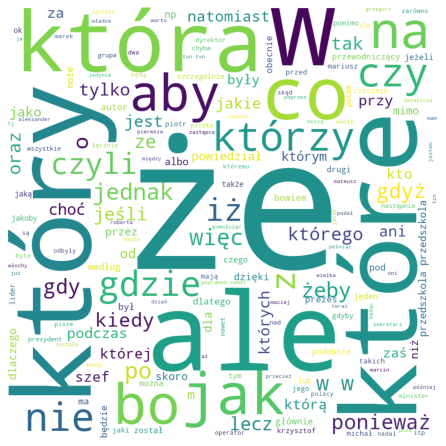

In [28]:
# visualization
plot_wordcloud(words_after_comma)

In [29]:
# words appearing after the fullstop
words_after_fullstop = get_words_after_char(data_train_exp_splitted, ".") # fullstop
pd.Series(words_after_fullstop).value_counts().head(10)

w         688
"         403
na        197
in        139
z         111
po        111
do        108
nie       105
to         99
według     87
dtype: int64

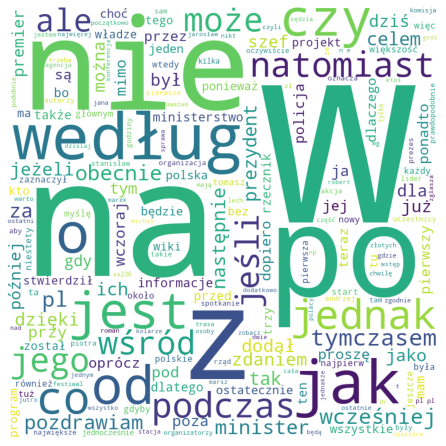

In [30]:
# visualization
plot_wordcloud(words_after_fullstop)

In [31]:
# words appearing after the question mark
words_after_question = get_words_after_char(data_train_exp_splitted, "?") # question mark
pd.Series(words_after_question).value_counts().head(10)

czy         31
w           25
nie         23
to          23
"           20
a           19
bo          12
tak         10
z           10
przecież    10
dtype: int64

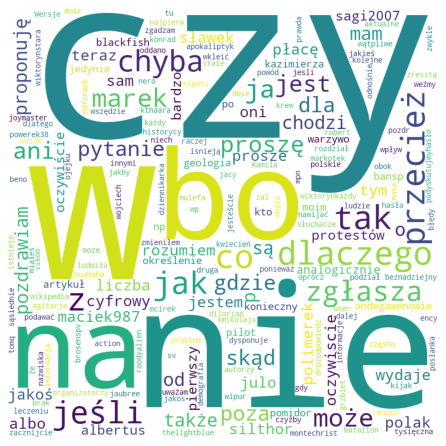

In [32]:
# visualization
plot_wordcloud(words_after_question)

In [33]:
# words appearing after the hyphen
words_after_hyphen = get_words_after_char(data_train_exp_splitted, "-")
pd.Series(words_after_hyphen).value_counts().head(10)

powiedział      117
w                39
stwierdził       32
"                32
mówił            28
dodał            26
poinformował     24
to               21
nie              20
u                19
dtype: int64

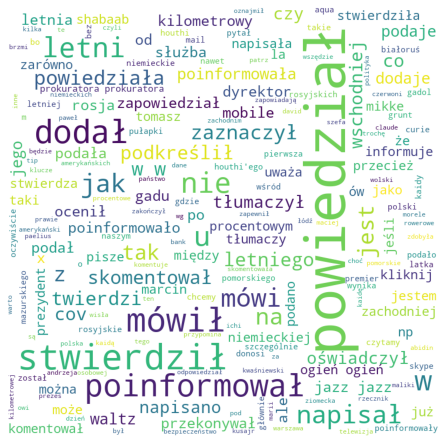

In [34]:
# visualization
plot_wordcloud(words_after_hyphen)

In [35]:
# morphological analysis - basic, to be continues in feature engineering part
morf = morfeusz2.Morfeusz()

analysis = morf.analyse(data_train_exp_sentences.loc[0, 'sentence'])
for i, j, interp in analysis:
    print(i, j, interp)

0 1 ('w', 'w', 'prep:acc:nwok', [], [])
0 1 ('w', 'w', 'prep:loc:nwok', [], [])
1 2 ('wywiadzie', 'wywiad', 'subst:sg:loc:m3', ['nazwa_pospolita'], [])
1 2 ('wywiadzie', 'wywiad', 'subst:sg:voc:m3', ['nazwa_pospolita'], [])
2 3 ('dla', 'dla', 'prep:gen', [], [])
3 4 ('"', '"', 'interp', [], [])
4 5 ('polski', 'polski:S', 'subst:sg:nom.acc:m3', ['nazwa_pospolita'], [])
4 5 ('polski', 'polski:S', 'subst:sg:voc:m3', ['nazwa_pospolita'], [])
4 5 ('polski', 'polski:A', 'adj:sg:acc:m3:pos', [], [])
4 5 ('polski', 'polski:A', 'adj:sg:nom.voc:m1.m2.m3:pos', [], [])
5 6 ('"', '"', 'interp', [], [])
6 7 ('jarosław', 'Jarosław:Sm3', 'subst:sg:nom.acc:m3', ['nazwa_geograficzna'], [])
6 7 ('jarosław', 'Jarosławy', 'subst:pl:gen:n:pt', ['człon_nazwy_geograficznej'], [])
6 7 ('jarosław', 'Jarosław:Sm1', 'subst:sg:nom:m1', ['imię'], [])
6 7 ('jarosław', 'Jarosława', 'subst:pl:gen:f', ['imię'], [])
7 8 ('kaczyński', 'Kaczyński', 'subst:sg:nom:m1', ['nazwisko'], [])
7 8 ('kaczyński', 'Kaczyński', 'subst

In [37]:
# morphological analysis
morf = morfeusz2.Morfeusz()
analysis_df = []
analysis = morf.analyse(data_train_exp_sentences.loc[0, 'sentence'])
for i, j, interp in analysis:
    row = [interp[0], interp[1].split(":")[0], interp[2].split(":")[0]]
    if len(interp[2].split(":")) < 3 :
        row = row
    else:
        row.append(interp[2].split(":")[2])
    analysis_df.append(row)
analysis_df = pd.DataFrame(analysis_df)
analysis_df.columns = ['word', 'base word', 'POS', 'Case or other']
analysis_df.head(15)

,word,base word,POS,Case or other
0,w,w,prep,nwok
1,w,w,prep,nwok
2,wywiadzie,wywiad,subst,loc
3,wywiadzie,wywiad,subst,voc
4,dla,dla,prep,None
5,"""","""",interp,None
6,polski,polski,subst,nom.acc
7,polski,polski,subst,voc
8,polski,polski,adj,acc
9,polski,polski,adj,nom.voc
